TV-Regularized Low-Dose CT Reconstruction
=========================================

This example demonstrates solution of a low-dose CT reconstruction problem
with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection),
$\mathbf{y}$ is the sinogram, the norm weighting $W$ is chosen so that
the weighted norm is an approximation to the Poisson negative log
likelihood <cite data-cite="sauer-1993-local"/>, $C$ is a 2D finite difference
operator, and $\mathbf{x}$ is the desired image.

In [1]:
import numpy as np

import jax

from xdesign import Soil, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray.astra import XRayTransform
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size

np.random.seed(0)
x_gt = discrete_phantom(Soil(porosity=0.80), size=384)
x_gt = np.ascontiguousarray(np.pad(x_gt, (64, 64)))
x_gt = np.clip(x_gt, 0, np.inf)  # clip to positive values
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 360  # number of projections
Io = 1e3  # source flux
𝛼 = 1e-2  # attenuation coefficient

angles = np.linspace(0, 2 * np.pi, n_projection)  # evenly spaced projection angles
A = XRayTransform(x_gt.shape, 1.0, N, angles)  # CT projection operator
y_c = A @ x_gt  # sinogram

Add Poisson noise to projections according to

$$\mathrm{counts} \sim \mathrm{Poi}\left(I_0 exp\left\{- \alpha A
\mathbf{x} \right\}\right)$$

$$\mathbf{y} = - \frac{1}{\alpha} \log\left(\mathrm{counts} /
I_0\right).$$

We use the NumPy random functionality so we can generate using 64-bit
numbers.

In [4]:
counts = np.random.poisson(Io * snp.exp(-𝛼 * A @ x_gt))
counts = np.clip(counts, a_min=1, a_max=np.inf)  # replace any 0s count with 1
y = -1 / 𝛼 * np.log(counts / Io)
y = jax.device_put(y)  # convert back to float32

Set up post processing. For this example, we clip all reconstructions
to the range of the ground truth.

In [5]:
def postprocess(x):
    return snp.clip(x, 0, snp.max(x_gt))

Compute an FBP reconstruction as an initial guess.

In [6]:
x0 = postprocess(A.fbp(y))

Set up and solve the un-weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;.$$

In [7]:
# Note that rho and lambda were selected via a parameter sweep (not
# shown here).
ρ = 2.5e3  # ADMM penalty parameter
lambda_unweighted = 3e2  # regularization strength

maxiter = 100  # number of ADMM iterations
cg_tol = 1e-5  # CG relative tolerance
cg_maxiter = 10  # maximum CG iterations per ADMM iteration

f = loss.SquaredL2Loss(y=y, A=A)

admm_unweighted = ADMM(
    f=f,
    g_list=[lambda_unweighted * functional.L21Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape, append=0)],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
admm_unweighted.solve()
x_unweighted = postprocess(admm_unweighted.x)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.64e+00  2.404e+07  5.755e+01  1.197e+02     10  5.986e-04


  10  8.47e+00  5.200e+06  4.310e+00  5.302e+00     10  4.992e-05


  20  1.08e+01  5.267e+06  7.188e-01  6.798e-01     10  1.015e-05


  30  1.28e+01  5.280e+06  4.211e-01  3.066e-01      5  9.675e-06


  40  1.44e+01  5.287e+06  2.976e-01  1.712e-01      4  9.746e-06


  50  1.59e+01  5.290e+06  2.312e-01  9.611e-02      1  9.044e-06


  60  1.73e+01  5.293e+06  1.903e-01  7.309e-02      3  6.971e-06


  70  1.87e+01  5.294e+06  1.610e-01  5.191e-02      3  6.897e-06


  80  2.00e+01  5.295e+06  1.387e-01  3.472e-02      2  8.061e-06


  90  2.13e+01  5.296e+06  1.206e-01  4.024e-02      3  5.555e-06


  99  2.24e+01  5.297e+06  1.081e-01  2.486e-02      2  7.904e-06


Set up and solve the weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where

  $$W = \mathrm{diag}\left\{ \mathrm{counts} / I_0 \right\} \;.$$

The data fidelity term in this formulation follows
<cite data-cite="sauer-1993-local"/> (9) except for the scaling by $I_0$, which we
use to maintain balance between the data and regularization terms if
$I_0$ changes.

In [8]:
lambda_weighted = 5e1

weights = jax.device_put(counts / Io)
f = loss.SquaredL2Loss(y=y, A=A, W=linop.Diagonal(weights))

admm_weighted = ADMM(
    f=f,
    g_list=[lambda_weighted * functional.L21Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape, append=0)],
    rho_list=[ρ],
    maxiter=maxiter,
    x0=x0,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 10},
)
admm_weighted.solve()
x_weighted = postprocess(admm_weighted.x)

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  5.76e-01  5.315e+06  9.950e+00  2.064e+01     10  1.404e-03


  10  3.29e+00  3.439e+06  9.724e-01  1.760e+01     10  1.081e-04


  20  5.77e+00  2.190e+06  1.083e+00  1.369e+01     10  1.158e-04


  30  8.22e+00  1.486e+06  9.219e-01  9.942e+00     10  9.922e-05


  40  1.07e+01  1.144e+06  8.045e-01  6.458e+00     10  8.325e-05


  50  1.31e+01  1.036e+06  5.633e-01  2.883e+00     10  5.363e-05


  60  1.55e+01  1.022e+06  2.147e-01  8.679e-01     10  1.792e-05


  70  1.79e+01  1.021e+06  8.207e-02  3.505e-01      9  8.761e-06


  80  1.99e+01  1.021e+06  4.981e-02  2.153e-01      7  8.721e-06


  90  2.16e+01  1.021e+06  3.444e-02  1.583e-01      5  9.735e-06


  99  2.31e+01  1.021e+06  2.628e-02  1.263e-01      5  8.050e-06


Show recovered images.

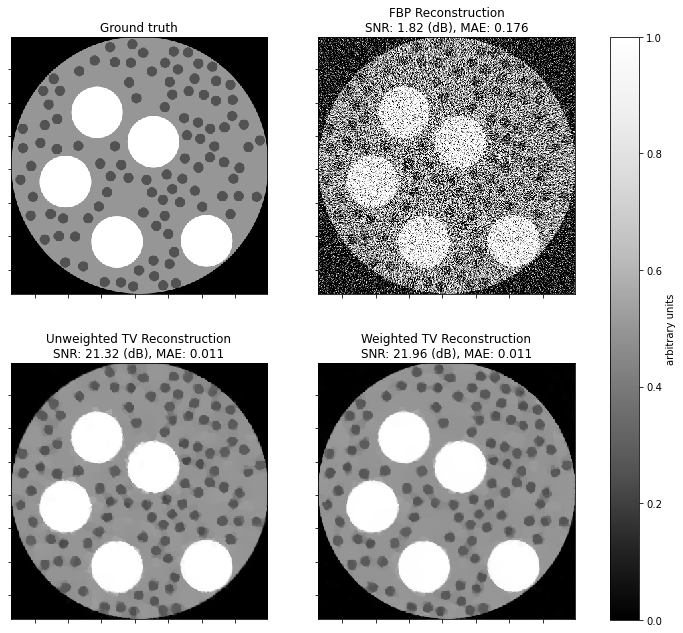

In [9]:
def plot_recon(x, title, ax):
    """Plot an image with title indicating error metrics."""
    plot.imview(
        x,
        title=f"{title}\nSNR: {metric.snr(x_gt, x):.2f} (dB), MAE: {metric.mae(x_gt, x):.3f}",
        fig=fig,
        ax=ax,
    )


fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0])
plot_recon(x0, "FBP Reconstruction", ax=ax[0, 1])
plot_recon(x_unweighted, "Unweighted TV Reconstruction", ax=ax[1, 0])
plot_recon(x_weighted, "Weighted TV Reconstruction", ax=ax[1, 1])
for ax_ in ax.ravel():
    ax_.set_xlim(64, 448)
    ax_.set_ylim(64, 448)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.show()